## Sélection des composants de l'ICA à l'aide de l'appariement des modèles
Lorsque l'on traite plusieurs sujets, il est également possible de sélectionner manuellement un CI à exclure sur un sujet, puis d'utiliser ce composant comme modèle pour sélectionner les CI à exclure des données des autres sujets, à l'aide de mne.preprocessing.corrmap [4]. L'idée derrière *corrmap* est que les modèles d'artefacts sont suffisamment similaires entre les sujets pour que les CI correspondants puissent être identifiés en corrélant les CI de chaque solution ICA avec un modèle commun, et en choisissant les CI avec la force de corrélation la plus élevée. corrmap prend une liste de solutions ICA, et un paramètre de modèle qui spécifie quel objet ICA et quel composant à l'intérieur de celui-ci doit être utilisé comme modèle.

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
# from sklearn.utils import shuffle

from mne import Epochs, pick_types, annotations_from_events, events_from_annotations, set_log_level, read_epochs
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP 
from mne.preprocessing import ICA, corrmap
# from mne.viz import plot_events, plot_montage

import joblib

Comme notre échantillon de données ne contient que les données d'un seul sujet, nous allons utiliser un autre ensemble de données comportant plusieurs sujets : l'ensemble de données EEGBCI [5][6]. L'ensemble de données comprend 109 sujets, nous téléchargerons simplement une exécution (une tâche de mouvement de la main gauche/droite) de chacun des 4 premiers sujets :

In [2]:
path = os.getenv('HOME') + '/sgoinfre'

icas = []
raws = []
for subject_nb in range(3):
    raw_fnames = eegbci.load_data(subject_nb + 1, runs=[3])
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    raw.resample(50)
    eegbci.standardize(raw)
    raw.set_montage("standard_1005")
    raw_filt = raw.copy().load_data().filter(l_freq=1.0, h_freq=None)
    # fit ICA, using low max_iter for speed

    ica = ICA(n_components=30, max_iter=100, random_state=97)
    ica.fit(raw_filt, verbose="error")
    icas.append(ica)
    raws.append(raw)

Extracting EDF parameters from /home/clorin/sgoinfre/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 165 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/clorin/sgoinfre/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 165 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/clorin/sgoinfre/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 165 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
/home/clorin/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Using EOG channels: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, CP5, CP3, CP1, CPz, CP2, CP4, CP6, Fp1, Fpz, Fp2, AF7, AF3, AFz, AF4, AF8, F7, F5, F3, F1, Fz, F2, F4, F6, F8, FT7, FT8, T7, T8, T9, T10, TP7, TP8, P7, P5, P3, P1, Pz, P2, P4, P6, P8, PO7, PO3, POz, PO4, PO8, O1, Oz, O2, Iz
EOG channel index for this subject is: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


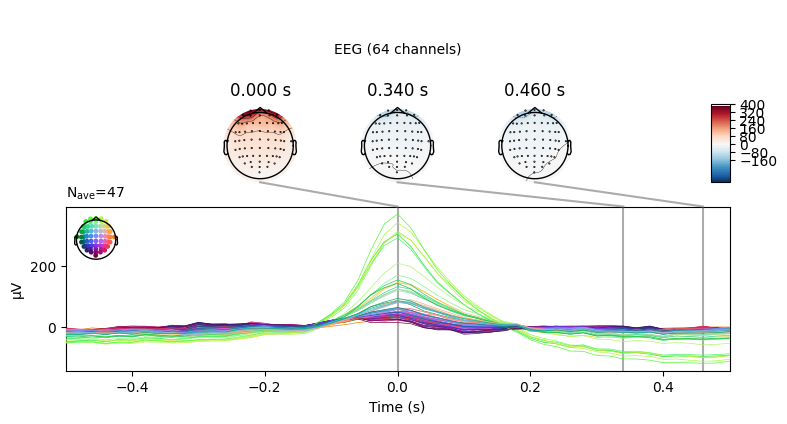

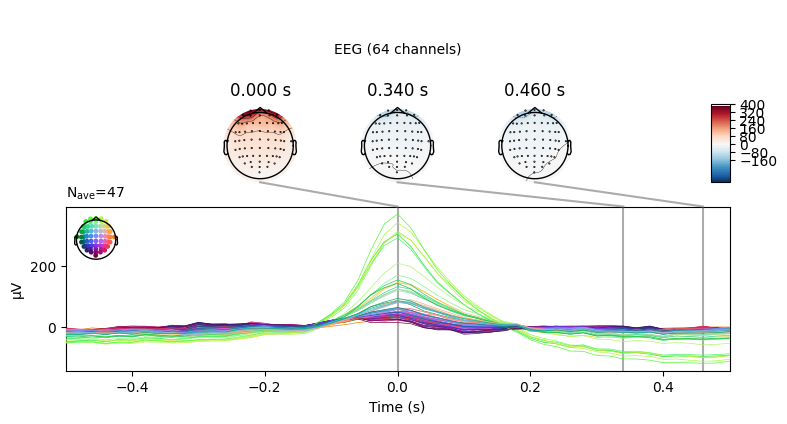

In [3]:
# use the first subject as template; use Fpz as proxy for EOG
from mne.preprocessing import create_eog_epochs
raw = raws[0]
ica = icas[0]
eog_evoked = create_eog_epochs(raw, ch_name=raw.info['ch_names']).average(picks="all")
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint()

Exécutons maintenant corrmap :

Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 500 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
-

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


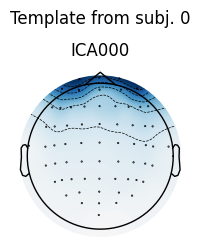

Median correlation with constructed map: 0.976
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


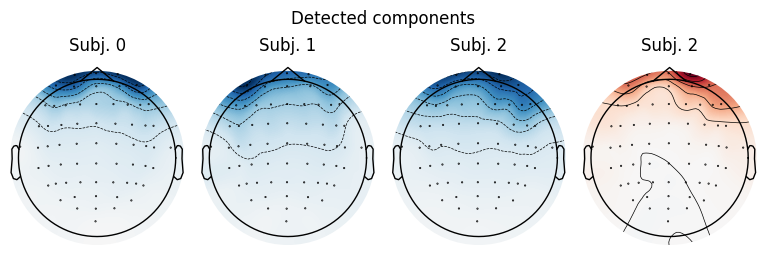

(<MNEFigure size 195x260.5 with 1 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>)

In [4]:

eog_inds, eog_scores = ica.find_bads_eog(raw, ch_name="Fpz")
corrmap(icas, template=(0, eog_inds[0]))


La première figure montre la carte du modèle, tandis que la seconde montre toutes les cartes qui ont été considérées comme correspondant au modèle (y compris le modèle lui-même). Il y a une correspondance pour chaque sujet, mais il est conseillé de revérifier les sources de l'ICA pour chaque sujet :

Using matplotlib as 2D backend.
Creating RawArray with float64 data, n_channels=30, n_times=6250
    Range : 0 ... 6249 =      0.000 ...   124.980 secs
Ready.


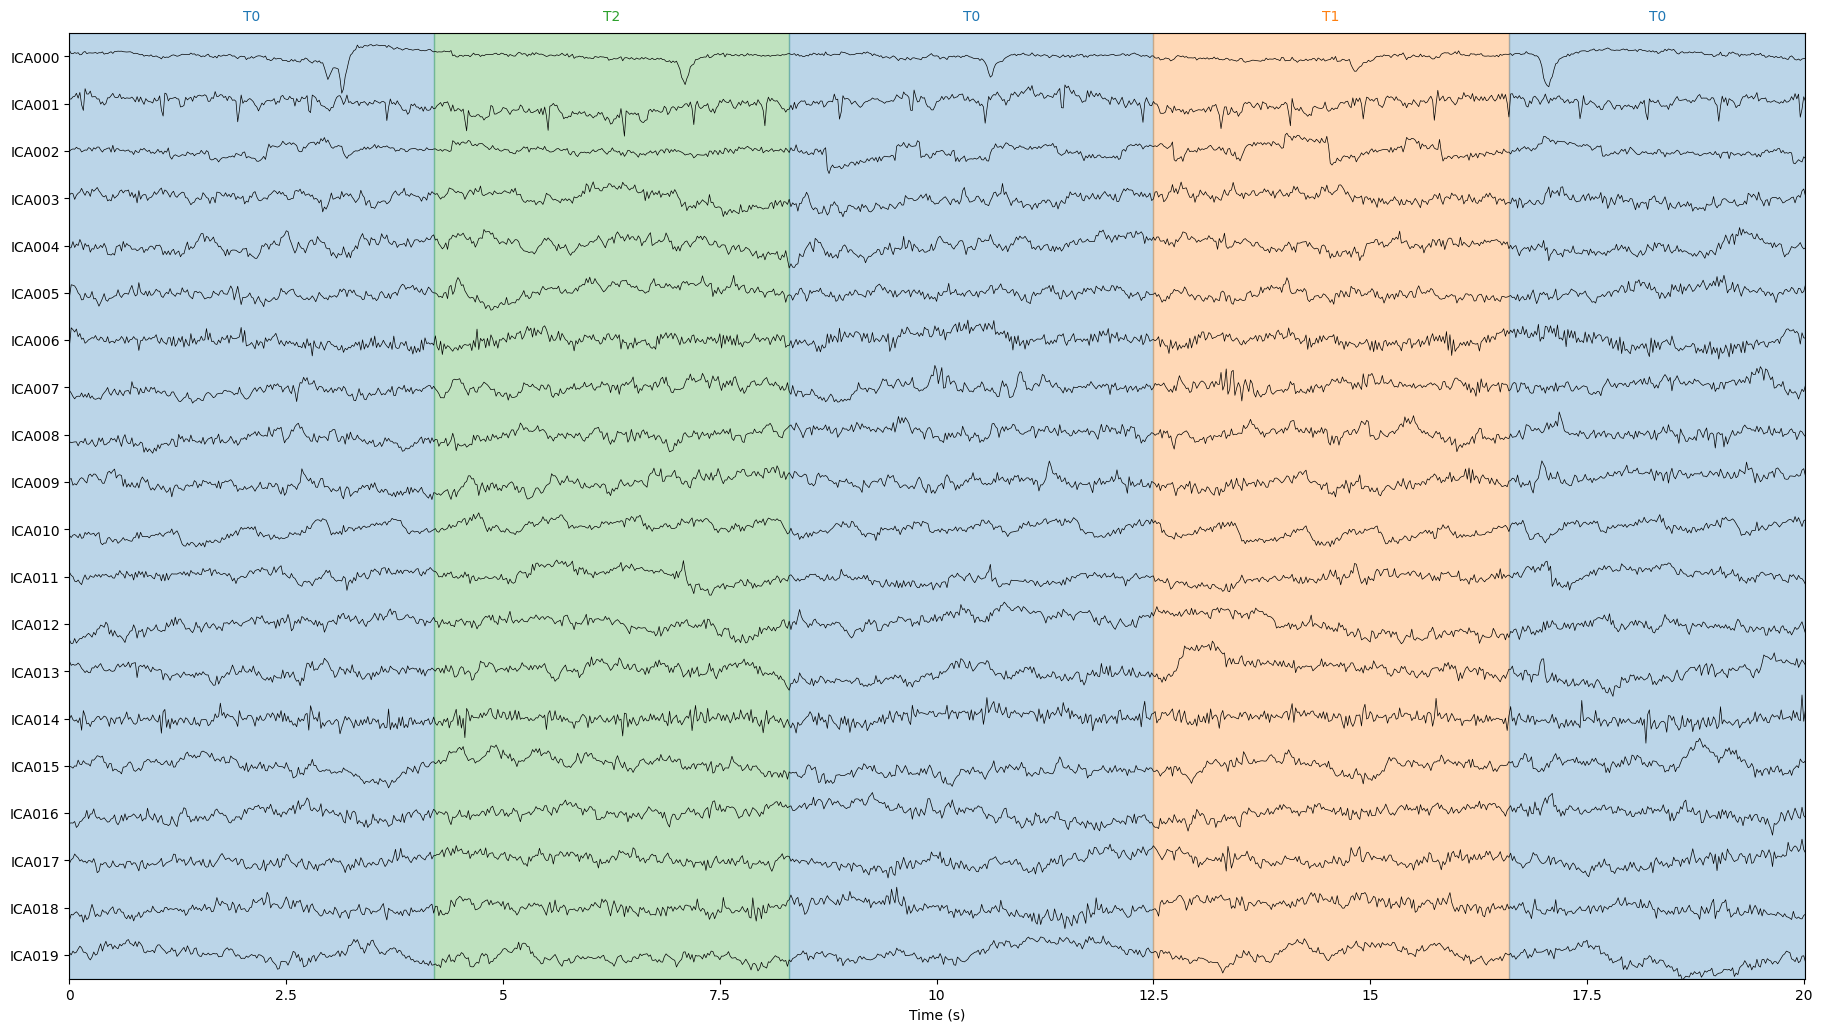

Creating RawArray with float64 data, n_channels=30, n_times=6150
    Range : 0 ... 6149 =      0.000 ...   122.980 secs
Ready.


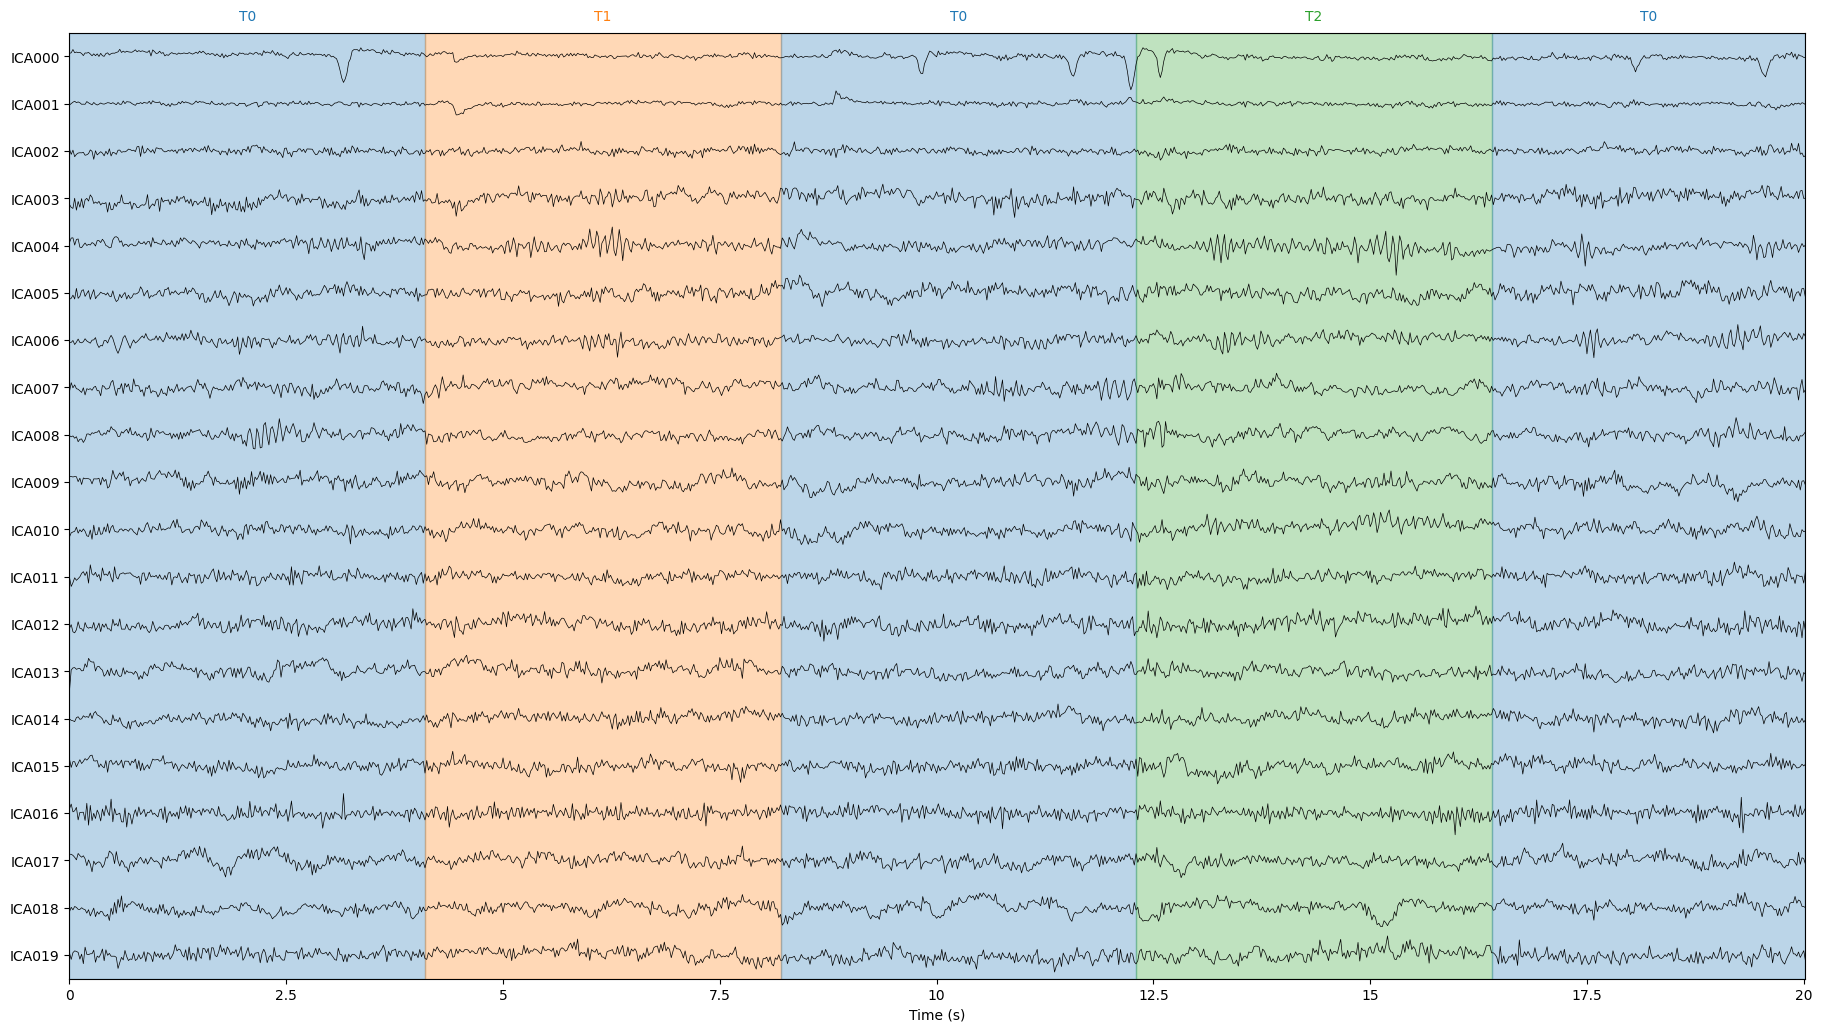

Creating RawArray with float64 data, n_channels=30, n_times=6250
    Range : 0 ... 6249 =      0.000 ...   124.980 secs
Ready.


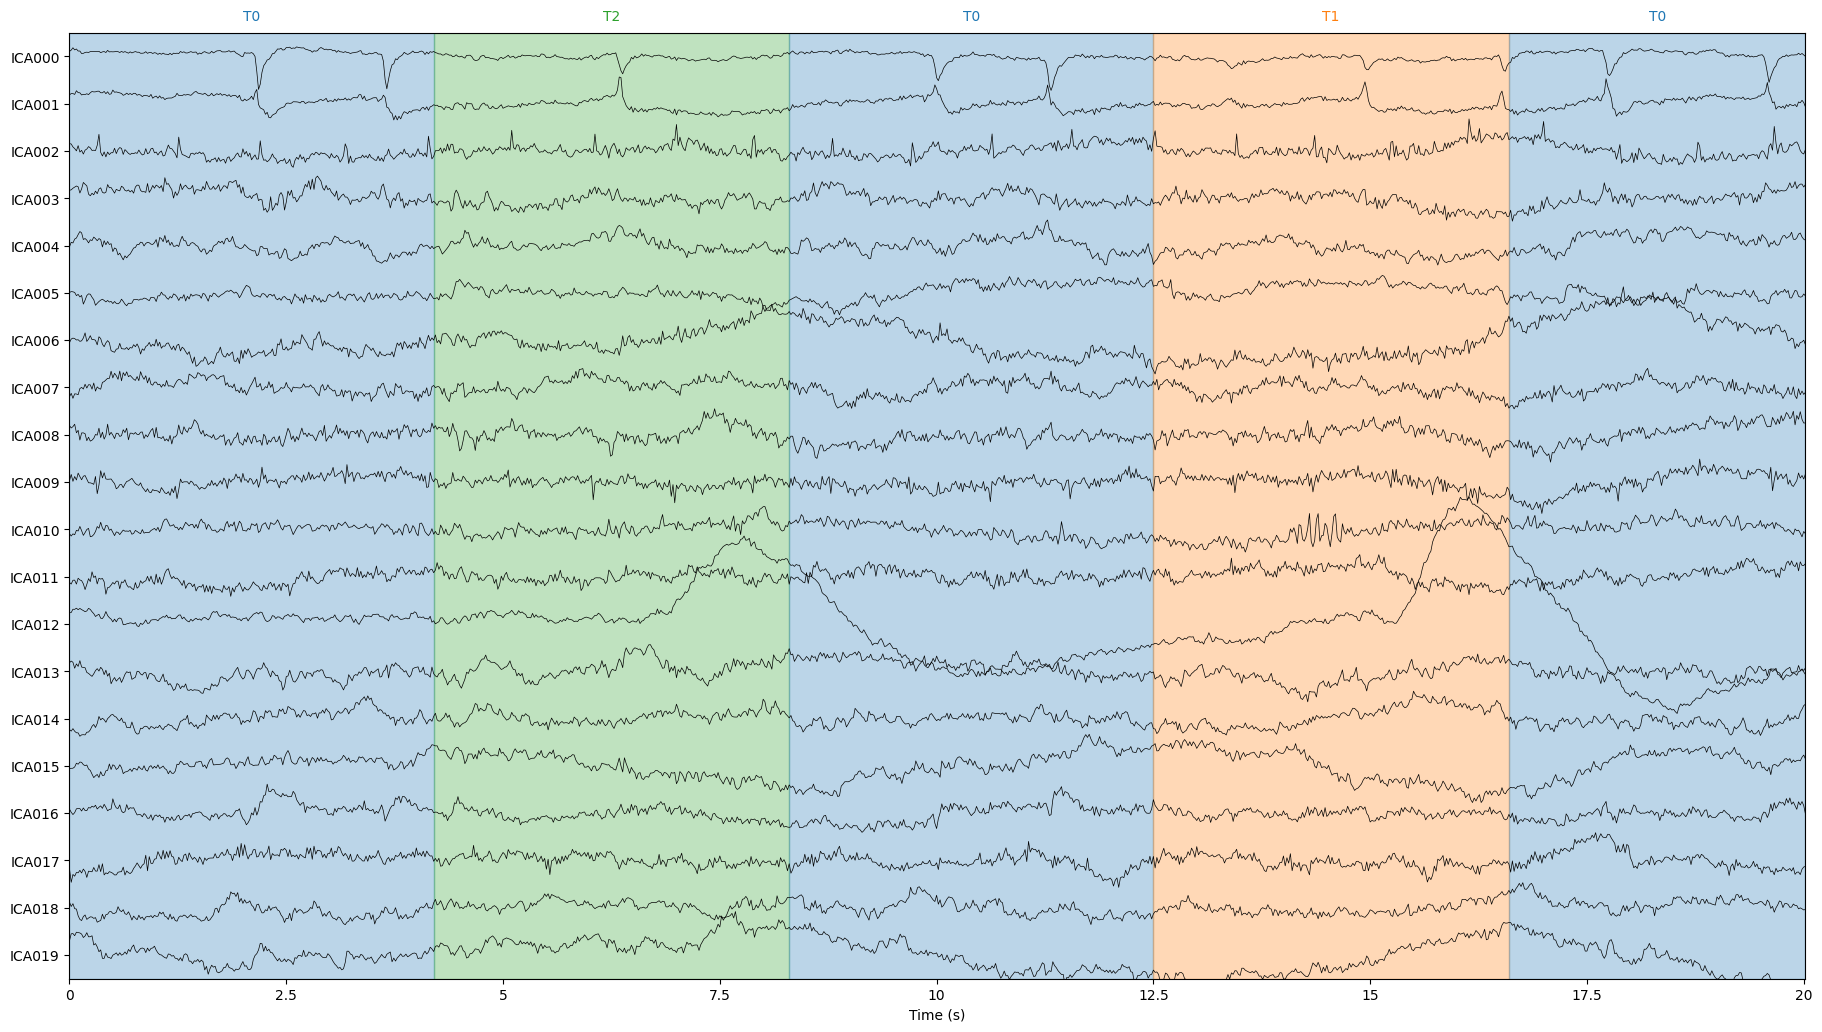

In [5]:
import mne
for index, (ica, raw) in enumerate(zip(icas, raws)):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = ica.plot_sources(raw, show_scrollbars=False)
    fig.subplots_adjust(top=0.9)  # make space for title
    fig.suptitle("Subject {}".format(index))

Remarquez que les sujets 2 et 3 semblent avoir chacun deux CI qui reflètent l'activité oculaire (composants ICA000 et ICA002), mais qu'un seul a été détecté par corrmap. Essayons de régler le seuil manuellement :

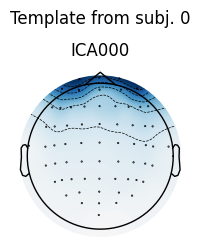

Median correlation with constructed map: 0.974
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


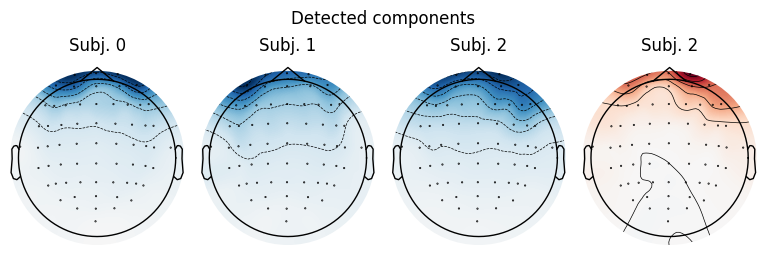

(<MNEFigure size 195x260.5 with 1 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>)

In [6]:
corrmap(icas, template=(0, eog_inds[0]), threshold=0.9)

Cette fois, il a trouvé 2 CI pour chacun des sujets 2 et 3 (ce qui est bien). À ce stade, nous allons réexécuter corrmap avec les paramètres label='blink', plot=False pour étiqueter les CI de chaque sujet qui capturent les artefacts de clignement (sans les représenter).

In [7]:
corrmap(icas, template=(0, eog_inds[0]), threshold=0.9, label="blink", plot=False)
print([ica.labels_ for ica in icas])


Median correlation with constructed map: 0.974
At least 1 IC detected for each subject.
[{'eog/0/Fpz': [0], 'eog': [0], 'blink': [0]}, {'blink': [0]}, {'blink': [0, 1]}]


Remarquez que le premier sujet a trois étiquettes différentes pour le CI à l'index 0 : "eog/0/Fpz", "eog" et "blink". Les deux premiers ont été ajoutés par find_bads_eog ; le label "blink" a été ajouté par le dernier appel à corrmap. Notez également que chaque sujet a au moins un indice IC étiqueté "blink", et que les sujets 2 et 3 ont chacun deux composantes (0 et 2) étiquetées "blink" (ce qui est cohérent avec le tracé des sources IC ci-dessus). L'attribut labels_ des objets ICA peut également être modifié manuellement pour annoter les CI avec des étiquettes personnalisées. Ces étiquettes s'avèrent également utiles lors de la représentation graphique 

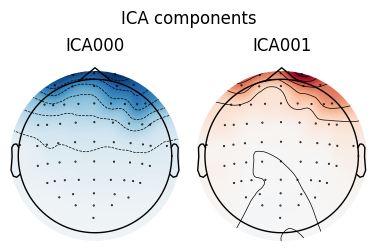

Creating RawArray with float64 data, n_channels=30, n_times=6250
    Range : 0 ... 6249 =      0.000 ...   124.980 secs
Ready.


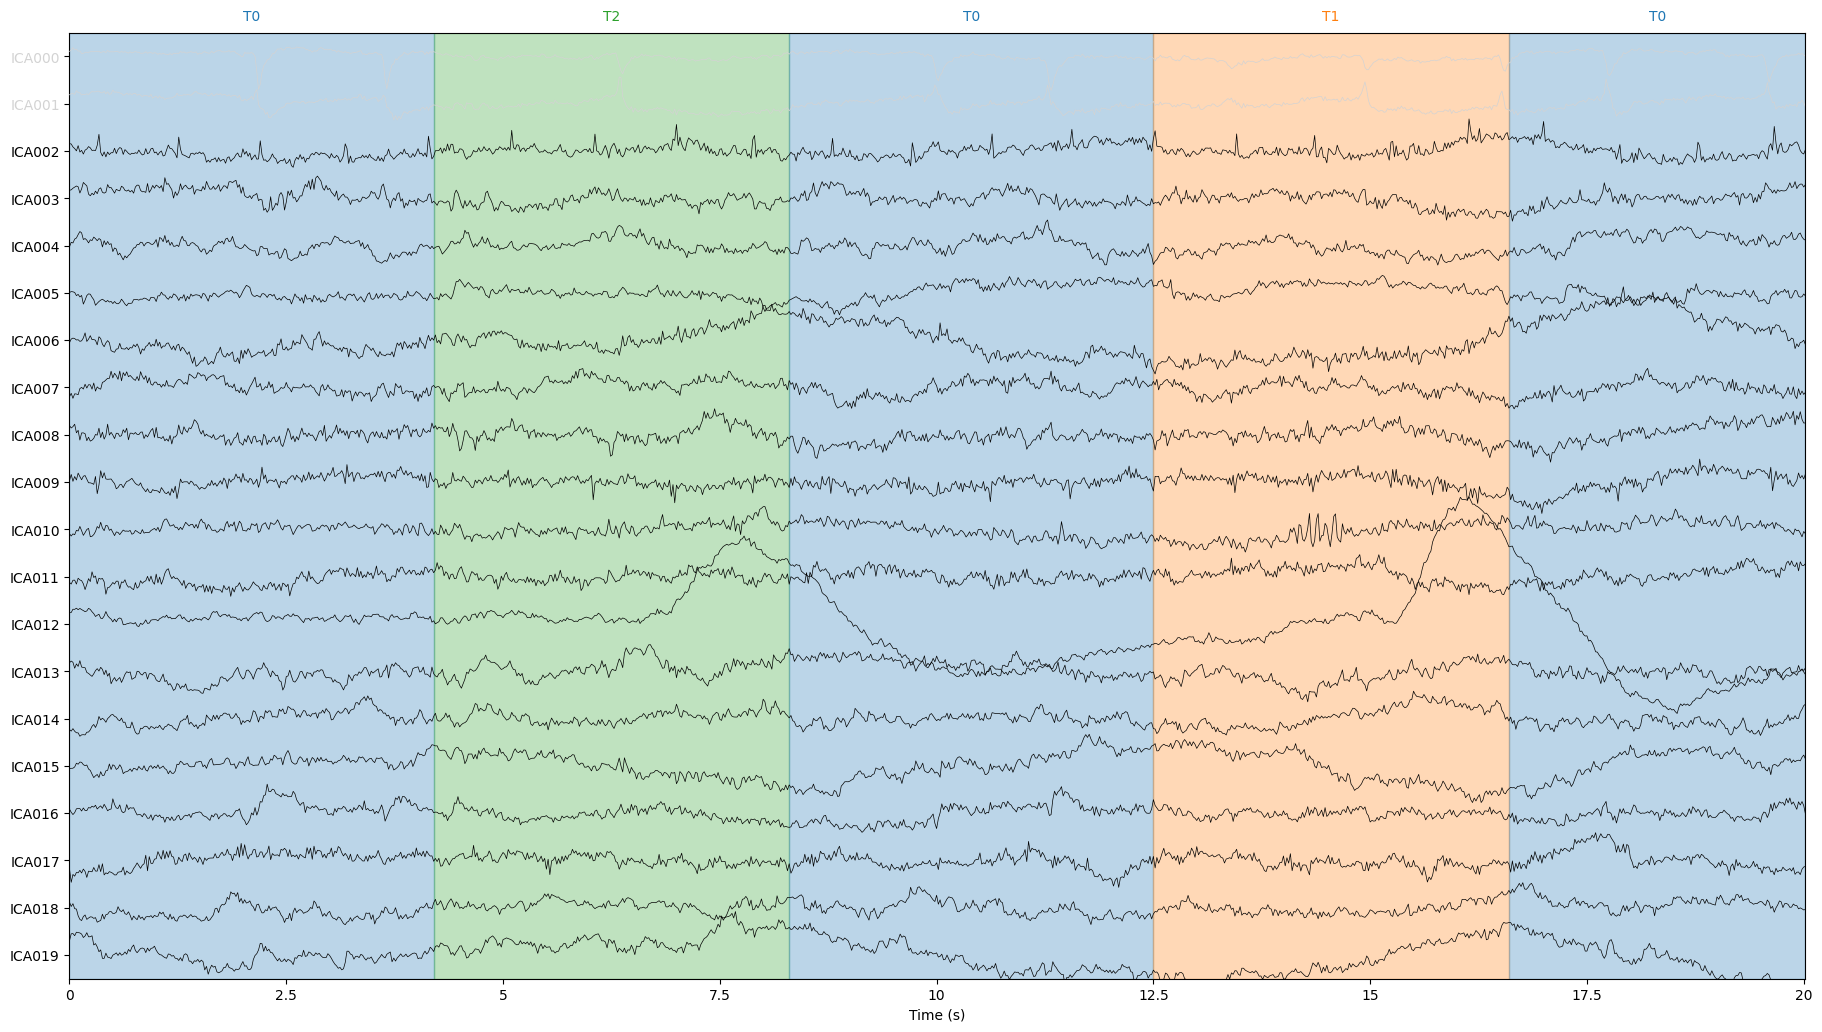

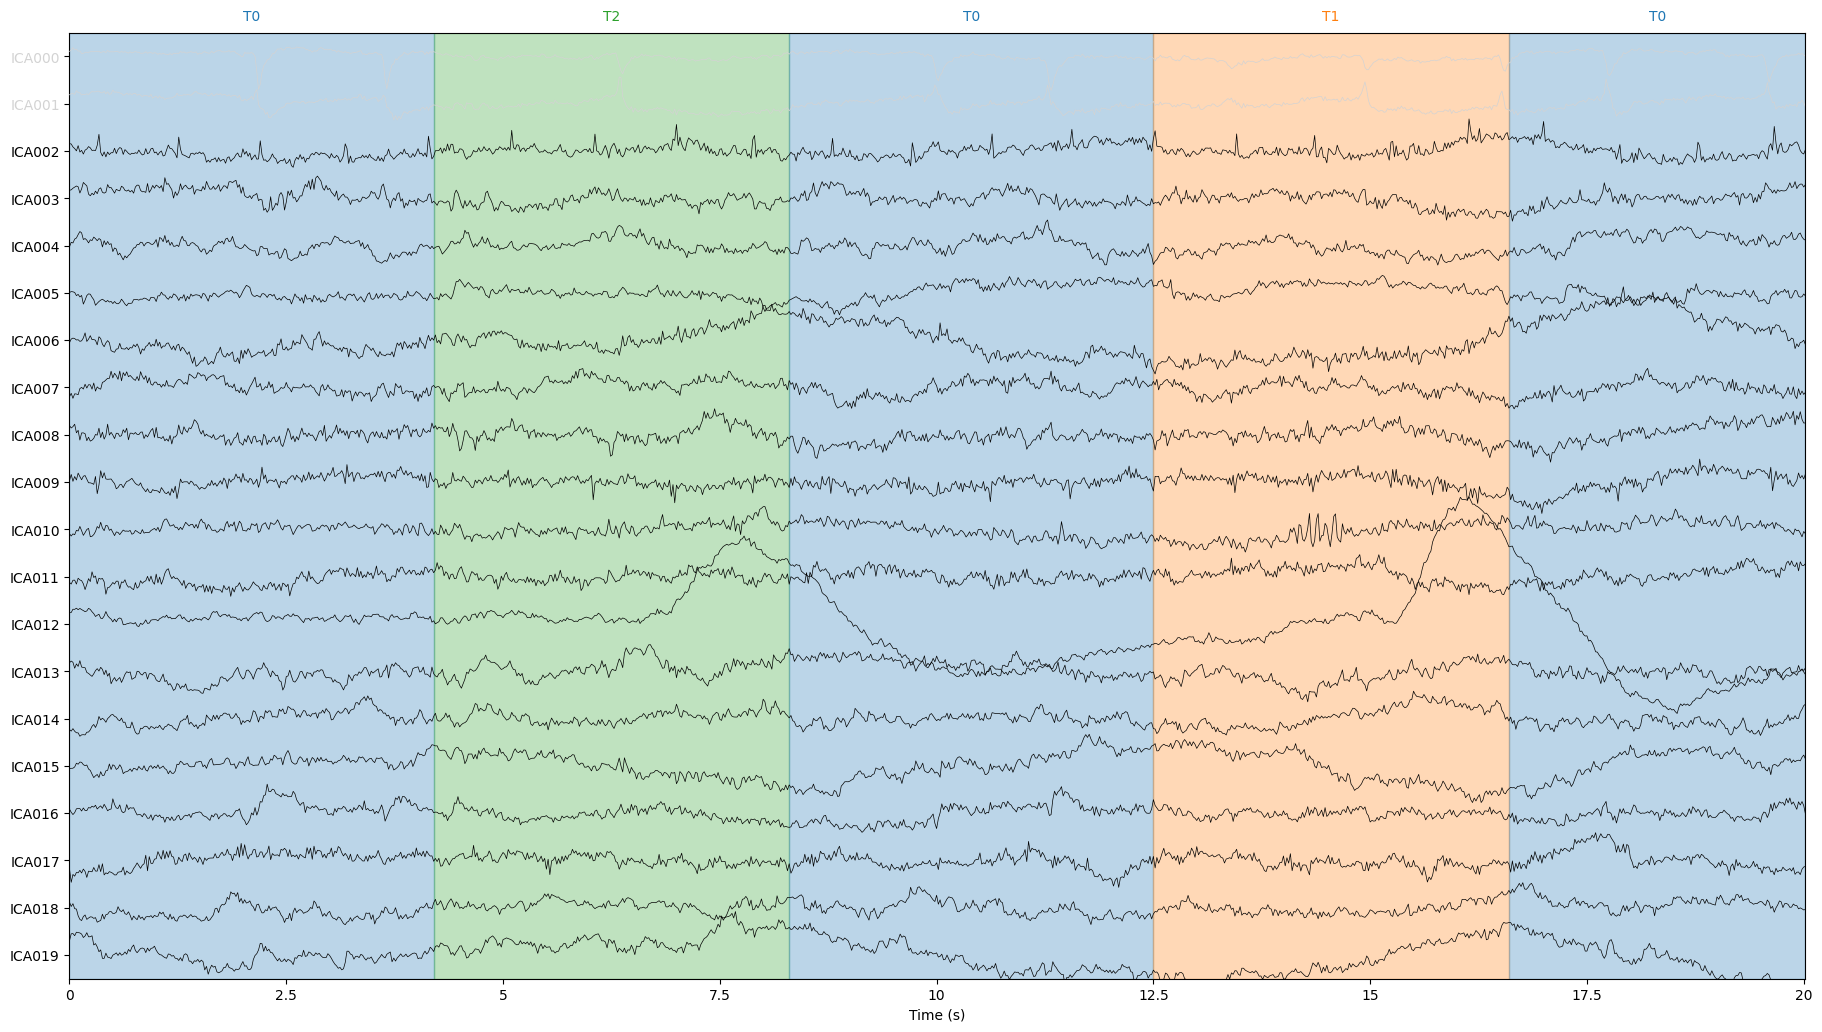

In [10]:
icas[2].plot_components(picks=icas[2].labels_["blink"])
icas[2].exclude = icas[2].labels_["blink"]
icas[2].plot_sources(raws[2], show_scrollbars=False)

Enfin, il est possible d'extraire les CI numériquement en utilisant la méthode get_components des objets ICA. Cette méthode renvoie un tableau NumPy qui peut être transmis à corrmap à la place du tuple (subject_index, component_index) que nous avons transmis précédemment, et donne le même résultat :

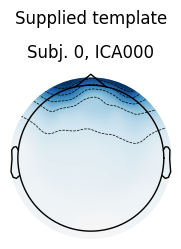

Median correlation with constructed map: 0.974
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


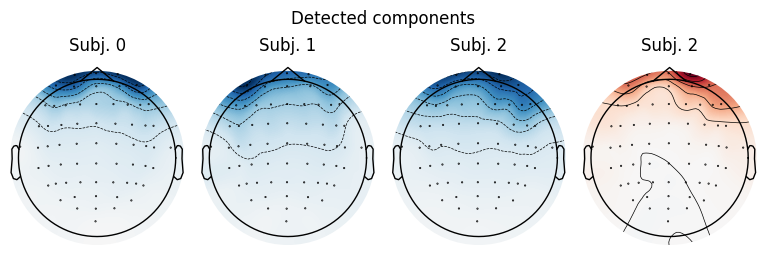

[-0.33638605 -0.32708878 -0.32846765 -0.32807248 -0.35916344 -0.37615216
 -0.42464993 -0.21789139 -0.22387812 -0.22237922 -0.21342143 -0.2425263
 -0.26757238 -0.27806995 -0.15470616 -0.1693302  -0.17711037 -0.17373137
 -0.19651749 -0.21091786 -0.22459439 -1.68783519 -1.46717407 -1.64182737
 -1.34165002 -1.28991817 -0.76938995 -1.0057612  -1.54311043 -0.54567127
 -0.63806031 -0.57058636 -0.52637437 -0.51788659 -0.55774431 -0.56188149
 -0.69340923 -0.73333856 -0.2829121  -0.39253171 -0.16120286 -0.25431324
 -0.06352167 -0.1647002  -0.11930156 -0.1811579  -0.10112171 -0.12638332
 -0.13623739 -0.1301851  -0.14380943 -0.15329772 -0.1715539  -0.16560352
 -0.13293812 -0.08175318 -0.10173655 -0.10764581 -0.12707317 -0.09785876
 -0.07433338 -0.08470678 -0.07373196 -0.03379354]


In [11]:
template_eog_component = icas[0].get_components()[:, eog_inds[0]]
corrmap(icas, template=template_eog_component, threshold=0.9)
print(template_eog_component)

Un avantage de l'utilisation de cette représentation numérique d'un CI pour capturer un modèle d'artefact particulier est qu'elle peut être sauvegardée et utilisée comme modèle pour de futures tâches de mise en correspondance de modèles à l'aide de corrmap sans avoir à charger ou à recalculer la solution ICA qui a produit le modèle à l'origine. En d'autres termes, lorsque le modèle est un tableau NumPy, l'objet ICA contenant le modèle n'a pas besoin d'être dans la liste des ICAs fournis à corrmap.